# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта:** Построить модель для определения рыночной стоимости автомобиля.

**Описание данных:** Датасет с историческими данными о продаже автомобилей: техническии характеристики, комплектации, цены и т.д.

## Подготовка данных

#### Импортируем необходимые библиотеки, считаем данные из csv-файла в датафрейм, сохраним в переменную и выведем ее и основную информацию о ней на экран

In [1]:
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### Предобработка данных

##### Избавимся от дубликатов

In [4]:
data.duplicated().sum()

4

In [5]:
# Удалим дубликаты:

data = data.drop_duplicates()

##### Найдем и изучим пропущенные значения в столбцах

In [6]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [7]:
data['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

Можно предположить, что там, где тип кузова не указан, должен быть "седан", как наиболее распространенный.

In [8]:
# Заменим пропущенные значения в столбце VehicleType на 'sedan':

data['VehicleType'] = data['VehicleType'].fillna('sedan')

In [9]:
data['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

Аналогичным образом, сейчас уже с большей вероятностью значением "по умолчанию" стоит считать автоматическую коробку передач.

In [10]:
# Заменим пропущенные значения в столбце Gearbox на 'auto':

data['Gearbox'] = data['Gearbox'].fillna('auto')

In [11]:
data['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [12]:
# Удалим строки с пропущенными значениями столбца Model:

data = data.dropna(subset=['Model'])

In [13]:
data['FuelType'].value_counts()

petrol      207159
gasoline     95856
lpg           4962
cng            544
hybrid         208
other          133
electric        66
Name: FuelType, dtype: int64

Скорее всего, в пропусках типа топлива должен быть бензин, как наиболее часто встречающийся.

In [14]:
# Заменим пропущенные значения в столбце FuelType на 'petrol':

data['FuelType'] = data['FuelType'].fillna('petrol')

In [15]:
data['Repaired'].value_counts()

no     238852
yes     33708
Name: Repaired, dtype: int64

Так же и с наличием ремонта: пропуски - это, вероятно, его отсутствие.

In [16]:
# Заменим пропущенные значения в столбце Repaired на 'no':

data['Repaired'] = data['Repaired'].fillna('no')

##### Найдем и устраним редкие и выбивающиеся значения

In [17]:
# Отсортируем значения столбца по возрастанию:

data['DateCreated'].sort_values()

61207     2014-03-10 00:00:00
4001      2015-03-20 00:00:00
342275    2015-06-18 00:00:00
86601     2015-08-07 00:00:00
175103    2015-08-10 00:00:00
                 ...         
216128    2016-04-07 00:00:00
285200    2016-04-07 00:00:00
292174    2016-04-07 00:00:00
206571    2016-04-07 00:00:00
124250    2016-04-07 00:00:00
Name: DateCreated, Length: 334660, dtype: object

In [18]:
data['DateCrawled'].sort_values()

329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
324763    2016-03-05 14:06:24
176823    2016-03-05 14:06:24
220604    2016-03-05 14:06:25
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, Length: 334660, dtype: object

In [19]:
data['LastSeen'].sort_values()

296785    2016-03-05 14:15:08
262341    2016-03-05 14:15:16
130462    2016-03-05 14:15:39
285695    2016-03-05 14:18:30
169065    2016-03-05 14:25:59
                 ...         
290312    2016-04-07 14:58:50
219959    2016-04-07 14:58:50
54852     2016-04-07 14:58:50
215705    2016-04-07 14:58:50
327303    2016-04-07 14:58:51
Name: LastSeen, Length: 334660, dtype: object

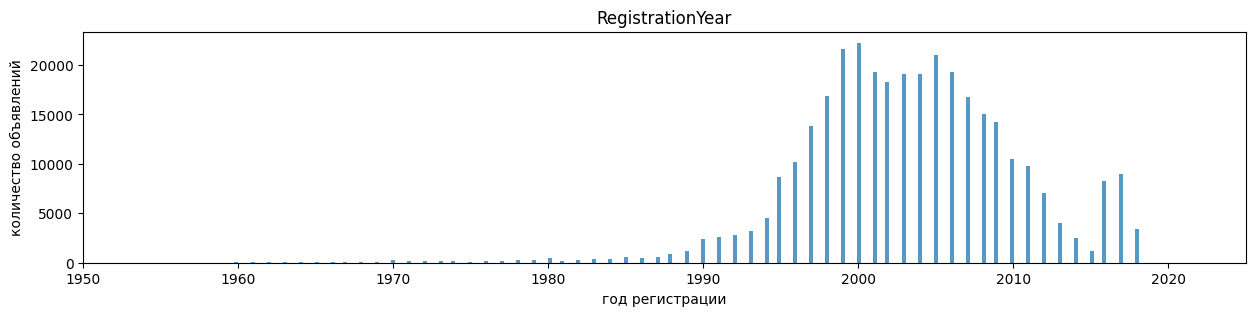

In [20]:
# Построим гистограммы для необходимых столбцов датафрейма:

plt.figure(figsize=(15,3))
sns.histplot(data['RegistrationYear']).set(title='RegistrationYear')

plt.xlim(1950, 2025)
plt.xlabel('год регистрации')
plt.ylabel('количество объявлений')
plt.show()

In [21]:
data = data[(data['RegistrationYear'] >= 1960) & (data['RegistrationYear'] <= 2016)]

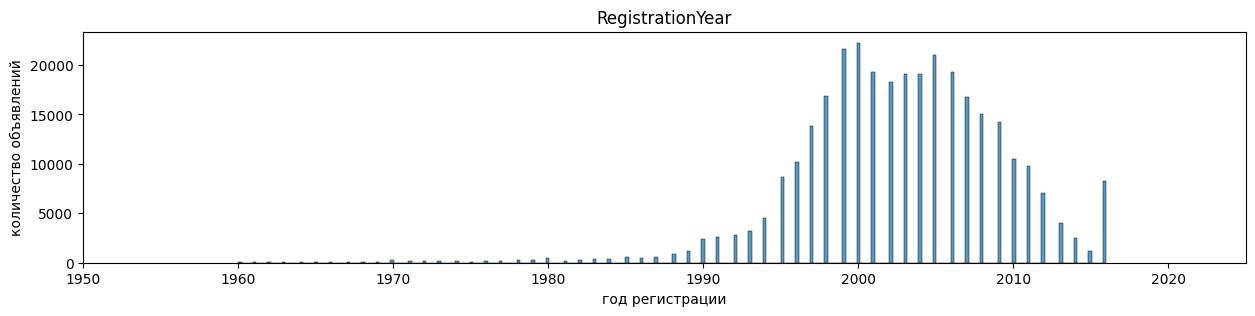

In [22]:
plt.figure(figsize=(15,3))
sns.histplot(data['RegistrationYear']).set(title='RegistrationYear')

plt.xlim(1950, 2025)
plt.xlabel('год регистрации')
plt.ylabel('количество объявлений')
plt.show()

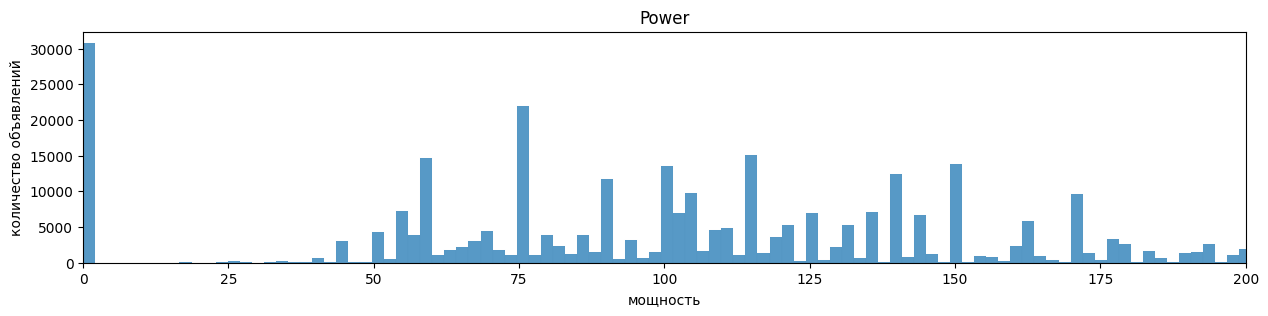

In [23]:
plt.figure(figsize=(15,3))
sns.histplot(data['Power']).set(title='Power')

plt.xlim(0, 200)
plt.xlabel('мощность')
plt.ylabel('количество объявлений')
plt.show()

In [24]:
data['Power'] = data['Power'].replace(to_replace=0, method='ffill')

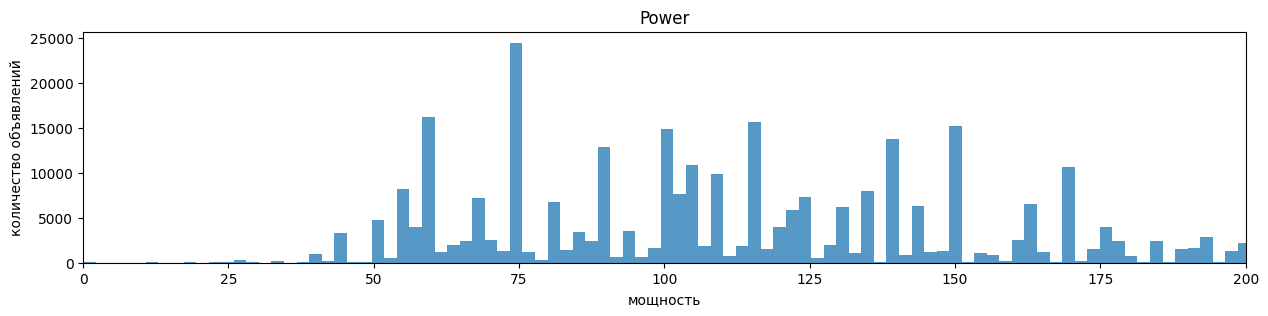

In [25]:
plt.figure(figsize=(15,3))
sns.histplot(data['Power']).set(title='Power')

plt.xlim(0, 200)
plt.xlabel('мощность')
plt.ylabel('количество объявлений')
plt.show()

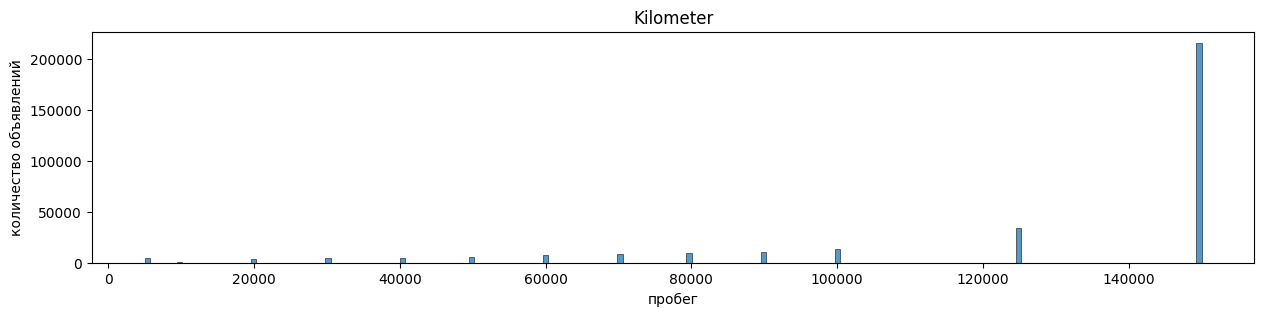

In [26]:
plt.figure(figsize=(15,3))
sns.histplot(data['Kilometer']).set(title='Kilometer')

plt.xlabel('пробег')
plt.ylabel('количество объявлений')
plt.show()

In [27]:
# Изучим список уникальных значений столбца:

data['Brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'porsche', 'rover', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

In [28]:
data['NumberOfPictures'].unique()

array([0])

##### Удалим столбцы, которые не понадобятся в дальнейшем

В столбце NumberOfPictures сплошь нулевые значения - он не поможет при обучении модели. Столбцы с датами и почтовым индексом владельца тоже вряд ли влияют на ценообразование.

In [29]:
data = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

In [30]:
# Выведем информацию об обновленном датафрейме:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321950 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              321950 non-null  int64 
 1   VehicleType        321950 non-null  object
 2   RegistrationYear   321950 non-null  int64 
 3   Gearbox            321950 non-null  object
 4   Power              321950 non-null  int64 
 5   Model              321950 non-null  object
 6   Kilometer          321950 non-null  int64 
 7   RegistrationMonth  321950 non-null  int64 
 8   FuelType           321950 non-null  object
 9   Brand              321950 non-null  object
 10  Repaired           321950 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.5+ MB


In [31]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


#### Подготовим выборки для обучения моделей

In [32]:
# Выделим из признаков и целевого признака тестовые:

data_1, data_test = train_test_split(data, test_size=0.2, random_state=12345)

In [33]:
# Разделим оставшиеся признаки и целевой признак на обучающие и валидационные:

data_train, data_valid = train_test_split(data_1, test_size=0.25, random_state=12345)

Проведем кодировку категориальных признаков датасета:

In [34]:
transformer = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']),
    remainder='passthrough')

transformer.fit(data_train)
data_train = pd.DataFrame(transformer.transform(data_train), columns=['VehicleType', 'Gearbox', 'Model',
                                                  'FuelType', 'Brand', 'Repaired', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'])
print(data_train.head())

   VehicleType  Gearbox  Model  FuelType  Brand  Repaired    Price  \
0          7.0      1.0   42.0       6.0   24.0       1.0    300.0   
1          5.0      1.0  166.0       6.0   33.0       0.0   3850.0   
2          4.0      0.0   49.0       6.0   37.0       0.0  19999.0   
3          7.0      1.0   95.0       4.0   20.0       1.0   1800.0   
4          0.0      0.0  223.0       6.0   37.0       1.0    450.0   

   RegistrationYear  Power  Kilometer  RegistrationMonth  
0            1999.0   75.0   150000.0                0.0  
1            2004.0   94.0    50000.0                7.0  
2            2015.0  105.0     5000.0               10.0  
3            1999.0  136.0   150000.0                3.0  
4            2000.0  116.0   150000.0                0.0  


In [35]:
data_valid = pd.DataFrame(transformer.transform(data_valid), columns=['VehicleType', 'Gearbox', 'Model',
                                                  'FuelType', 'Brand', 'Repaired', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'])
print(data_valid.head())

   VehicleType  Gearbox  Model  FuelType  Brand  Repaired    Price  \
0          7.0      1.0   11.0       2.0    2.0       0.0  12700.0   
1          4.0      1.0  116.0       6.0   37.0       0.0  13250.0   
2          0.0      1.0  161.0       6.0   23.0       0.0   4490.0   
3          4.0      1.0   11.0       6.0    2.0       1.0   2000.0   
4          5.0      1.0  244.0       2.0   35.0       0.0   4200.0   

   RegistrationYear  Power  Kilometer  RegistrationMonth  
0            2010.0  143.0   100000.0               11.0  
1            2014.0  105.0    20000.0                8.0  
2            2008.0   88.0   125000.0                4.0  
3            2001.0  116.0   150000.0               11.0  
4            2007.0   90.0   150000.0                6.0  


In [36]:
data_test = pd.DataFrame(transformer.transform(data_test), columns=['VehicleType', 'Gearbox', 'Model',
                                                  'FuelType', 'Brand', 'Repaired', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'])
print(data_test.head())

   VehicleType  Gearbox  Model  FuelType  Brand  Repaired   Price  \
0          5.0      0.0  244.0       6.0   35.0       0.0  7000.0   
1          1.0      1.0   29.0       6.0    1.0       0.0  7999.0   
2          4.0      1.0  166.0       6.0   10.0       0.0  3600.0   
3          1.0      1.0   42.0       6.0   24.0       0.0     1.0   
4          4.0      1.0  149.0       2.0   27.0       0.0  4400.0   

   RegistrationYear  Power  Kilometer  RegistrationMonth  
0            2008.0   87.0    70000.0                6.0  
1            2004.0  163.0   150000.0                6.0  
2            1968.0   58.0   125000.0                5.0  
3            2002.0  150.0   150000.0                6.0  
4            2004.0  120.0    50000.0                6.0  


In [37]:
# Выделим из датасета признаки и целевой признак:

target_train = data_train['Price']
features_train = data_train.drop(['Price'], axis=1)

In [38]:
target_valid = data_valid['Price']
features_valid = data_valid.drop(['Price'], axis=1)

In [39]:
target_test = data_test['Price']
features_test = data_test.drop(['Price'], axis=1)

Проведем масштабирование численных признаков:

In [40]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head())

   VehicleType  Gearbox  Model  FuelType  Brand  Repaired  RegistrationYear  \
0          7.0      1.0   42.0       6.0   24.0       1.0         -0.564243   
1          5.0      1.0  166.0       6.0   33.0       0.0          0.200533   
2          4.0      0.0   49.0       6.0   37.0       0.0          1.883042   
3          7.0      1.0   95.0       4.0   20.0       1.0         -0.564243   
4          0.0      0.0  223.0       6.0   37.0       1.0         -0.411288   

      Power  Kilometer  RegistrationMonth  
0 -0.253688   0.579655          -1.590972  
1 -0.156718  -2.105718           0.316052  
2 -0.100577  -3.314136           1.133348  
3  0.057637   0.579655          -0.773676  
4 -0.044437   0.579655          -1.590972  


**Вывод:** Пропущенные значения в столбце VehicleType заменены на 'sedan'; в столбце Gearbox - на 'auto'; в столбце FuelType - на 'petrol'; в столбце Repaired - на 'no'. Удалены строки с пропущенными значениями в столбце Model. Нулевые значения в столбце Power заменены предыдущими ненулевыми. Из столбца RegistrationYear удалены значения ранее 1960-го и позднее 2016-го года.

Столбцы DateCreated, DateCrawled, PostalCode, LastSeen и NumberOfPictures удалены за ненадобностью. Также, из датасета удалены дубликаты. Общая потеря данных составила 9%.

Произведено кодирование категориальных и масштабирование численных признаков. Датасет разделен на тестовую, обучающую и валидационную выборки. Выделены признаки и целевой признак.

## Обучение и анализ моделей

In [41]:
# Создадим цикл и определим глубину дерева для модели DecisionTreeRegressor при
# наилучшем значении RMSE:

best_model = None
best_result = 10000
best_depth = 0

for depth in range(1, 100):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5

    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("RMSE лучшей модели:", best_result, "Глубина дерева:", best_depth)

RMSE лучшей модели: 2115.9119137628572 Глубина дерева: 12


Определим время обучения лучшей модели:

In [42]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=12)
model.fit(features_train, target_train)

CPU times: user 543 ms, sys: 2.03 ms, total: 545 ms
Wall time: 545 ms


DecisionTreeRegressor(max_depth=12, random_state=12345)

И время предсказания:

In [43]:
%%time

predictions_valid = model.predict(features_valid)
print("RMSE =", mean_squared_error(target_valid, predictions_valid) ** 0.5)

RMSE = 2115.9119137628572
CPU times: user 14.1 ms, sys: 0 ns, total: 14.1 ms
Wall time: 15.4 ms


In [44]:
# Создадим вложенный цикл и определим число деревьев в ансамбле и минимальное количество семплов
# для LGBMRegressor при наилучшем значении RMSE:

best_model = None
best_result = 0
best_iterations = 0
best_leaf = 0

for itr in range(90, 110):
    for leaf in range(10, 20):
        model = LGBMRegressor(num_iterations=itr, min_data_in_leaf=leaf, verbose=-1)     # С помощью verbose я пытался уменьшить количество выводимых моделью оповещений

        features_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features_train.columns]
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = mean_squared_error(target_valid, predictions_valid) ** 0.5

        if result > best_result:
            best_model = model
            best_result = result
            best_iterations = itr
            best_leaf = leaf

print("RMSE лучшей модели:", best_result, "Число деревьев в ансамбле:", best_iterations, "Минимальное количество семплов:", best_leaf)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

RMSE лучшей модели: 1858.3478512436945 Число деревьев в ансамбле: 90 Минимальное количество семплов: 14


Обучим и определим затраченное на это время для модели LGBMRegressor:

In [45]:
%%time

model = LGBMRegressor(num_iterations=90, min_data_in_leaf=14)

# Избавимся от символов в названиях столбцов, которые вызывают ошибку при обучении
# данной модели:
features_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features_train.columns]

model.fit(features_train, target_train)

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 193170, number of used features: 10
[LightGBM] [Info] Start training from score 4550.850370
CPU times: user 1.54 s, sys: 8.01 ms, total: 1.55 s
Wall time: 1.53 s


LGBMRegressor(min_data_in_leaf=14, num_iterations=90)

Определим для нее время предсказания:

In [46]:
%%time

predictions_valid = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_valid)
print("RMSE =", mse ** 0.5)

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
RMSE = 1858.3478512436945
CPU times: user 455 ms, sys: 981 µs, total: 456 ms
Wall time: 458 ms


**Вывод:** В результате обучения и анализа моделей, наилучшим образом себя показала LGBMRegressor c числом деревьев в ансамбле, равным 90-та, и минимальным количеством семплов, равным 14-ти. Значение метрики RMSE для нее составило 1858. Время обучения модели: 1.53 секунды. Время предсказания: 458 миллисекунд. Временные показатели LGBMRegressor выше, чем у DecisionTreeRegressor, но, с учетом того, что значения, в целом, относительно маленькие и разницы по RMSE (1858 против 2116-ти), думаю, стоит остановить выбор на первой.

## Проверка модели

In [47]:
# Проверим наилучшую модель на тестовой выборке:

model = LGBMRegressor(num_iterations=90, min_data_in_leaf=14)
features_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features_train.columns]
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
mse = mean_squared_error(target_test, predictions_test)
print("RMSE =", mse ** 0.5)

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 193170, number of used features: 10
[LightGBM] [Info] Start training from score 4550.850370
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
RMSE = 1851.5283068749243


**Вывод:** При проверке модели LGBMRegressor на тестовой выборке значение метрики RMSE составило 1852.

## Общий вывод

В ходе предобработки данных пропущенные значения в столбце VehicleType заменены на 'sedan'; в столбце Gearbox - на 'auto'; в столбце FuelType - на 'petrol'; в столбце Repaired - на 'no'. Удалены строки с пропущенными значениями в столбце Model. Нулевые значения в столбце Power заменены предыдущими ненулевыми. Из столбца RegistrationYear удалены значения ранее 1960-го и позднее 2016-го года. Столбцы DateCreated, DateCrawled, PostalCode, LastSeen и NumberOfPictures удалены за ненадобностью. Также, из датасета удалены дубликаты. Произведено кодирование категориальных и масштабирование численных признаков. Датасет разделен на тестовую, обучающую и валидационную выборки. Выделены признаки и целевой признак.

В результате обучения и анализа моделей, наилучшим образом себя показала LGBMRegressor c числом деревьев в ансамбле, равным 90-та, и минимальным количеством семплов, равным 14-ти. Значение метрики RMSE для нее составило 1858. Время обучения модели: 1.53 секунды. Время предсказания: 458 миллисекунд.

При проверке модели LGBMRegressor на тестовой выборке значение метрики RMSE составило 1852.